# Intercellular distance analysis

🎯 **Goal**: Explore intercellular distance data.

---

## Context

Quantifying the intercellular distance requires choosing an adequate number of neighbors to analyze. Thus, we will explore how this value influences the distance between cells and define it accordingly.

We will be looking into experimental and computational data and performing statistical tests for each group.

In [1]:
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats
from scipy.spatial import distance as dist

sys.path.insert(1, '../optimization')
import optimization

## Read the experimental data

The experimental data includes more conditions than we analyzed with the computational study, so we will be selecting the conditions we have studied.

In [3]:
dist_df = pd.read_csv("distances-data/experimental/pdgf-neighborhood.csv",
                      header=None, names=['condition', 'neighborhood', 'value'])

# Getting data for the  computational conditions
chemotaxis_df = dist_df[dist_df['condition'].str.contains('quimiotaxis')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('TG2')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('1_5mgml')]
high_density_df = chemotaxis_df[chemotaxis_df['condition'].str.contains('4mgml')]

Now that we have the data, we can start analyzing it. 

### Number of neighbors

Firstly, we will be looking at the effect of the number of neighbors for the 1 channel, 2.5 mg/mL study.

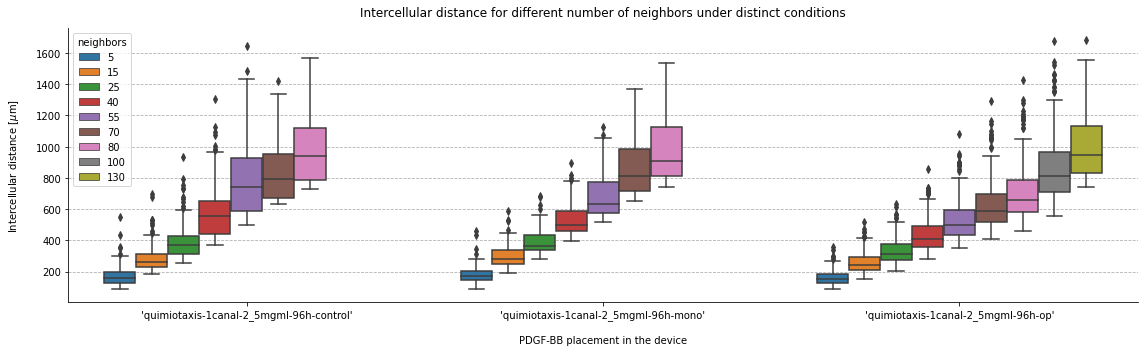

In [4]:
# Getting data for one channel, 2.5 mg/mL experiments
single_chamber = chemotaxis_df['condition'].str.contains('1canal')
single_df = chemotaxis_df[single_chamber]
conditions = ["'quimiotaxis-1canal-2_5mgml-96h-control'",
              "'quimiotaxis-1canal-2_5mgml-96h-mono'",
              "'quimiotaxis-1canal-2_5mgml-96h-op'"]

fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=single_df[single_df['neighborhood'].isin([5, 15, 25, 40, 55, 70, 80, 100, 130])], 
            x='condition', y='value', 
            order = conditions,
            hue='neighborhood', ax=ax)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Intercellular distance for different number of neighbors under distinct conditions', y=1.02)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

Based on the previous plot, we can conclude two things:
- Up until 40 neighbors, the results for all three conditions seem to be similar (we will look into this to confirm it later on);
- For more than 40 neighbors, the results for the monolayer channel see to be consistent with those obtained under control conditions. Yet,the distance values for the opposite channel results seem to be smaller when directly compared to the results obtained for the same number of neighbors in the other conditions. 

In addition, the opposite channel results include more data for a larger number of neighbors (>100). We suggest that this could be due to proliferation. As cells proliferate they would be closer to each other (hence the smaller distances for the same number of neighbors), and there would be a larger number of cells.

### Statistical differences

In [5]:
control_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('control')]
mono_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('mono')]
opp_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('op')]

#### Statistical differences between neighbor numbers

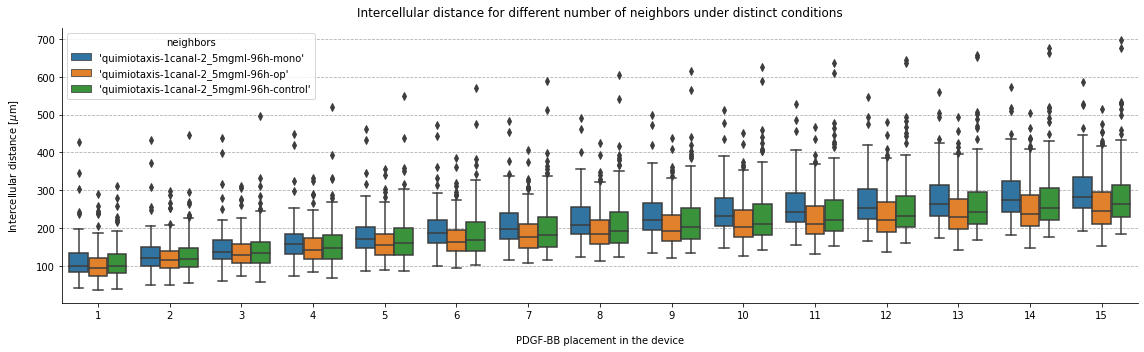

In [6]:
# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=single_df[single_df['neighborhood'].between(1, 15)], 
            x='neighborhood', y='value', 
            hue='condition', ax=ax)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Intercellular distance for different number of neighbors under distinct conditions', y=1.02)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

p_thresh = 0.05

for neighbors in range(1, 7):
    data_control = control_df[control_df['neighborhood'] == neighbors]['value'].values
    data_mono = mono_df[mono_df['neighborhood'] == neighbors]['value'].values
    data_opp = opp_df[opp_df['neighborhood'] == neighbors]['value'].values

    fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

    print(pvalue)

0.02589403626078274
0.07405308109194857
0.03187453329749018
0.005873544746601113
0.0013866395045649654
0.00045446372003196634


In [8]:
neighbor_data = single_df[single_df['neighborhood'] == 15]
tukey = pairwise_tukeyhsd(neighbor_data['value'], neighbor_data['condition'], alpha=p_thresh)
print(tukey)

                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
                 group1                                  group2                meandiff p-adj   lower    upper   reject
-----------------------------------------------------------------------------------------------------------------------
'quimiotaxis-1canal-2_5mgml-96h-control' 'quimiotaxis-1canal-2_5mgml-96h-mono'  11.3536 0.5115 -12.7906  35.4977  False
'quimiotaxis-1canal-2_5mgml-96h-control'   'quimiotaxis-1canal-2_5mgml-96h-op' -29.9338  0.001 -48.4211 -11.4466   True
   'quimiotaxis-1canal-2_5mgml-96h-mono'   'quimiotaxis-1canal-2_5mgml-96h-op' -41.2874  0.001 -63.2809 -19.2939   True
-----------------------------------------------------------------------------------------------------------------------


## Final data

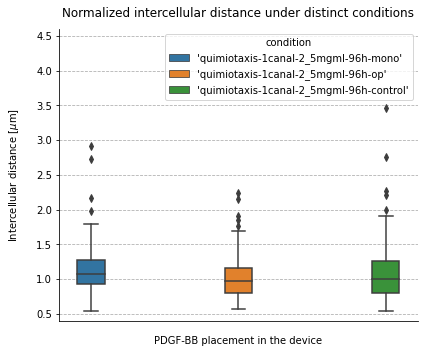

In [9]:
normalized_df = single_df.copy()

neighbors = 5
normalized_df = normalized_df[normalized_df['neighborhood'] == neighbors]
control_norm = normalized_df[normalized_df['condition'] == "'quimiotaxis-1canal-2_5mgml-96h-control'"]
normalization_value = np.median(control_norm['value'])

normalized_df['norm_value'] = normalized_df['value']/normalization_value

# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data=normalized_df, 
            x='condition', y='norm_value', 
            hue='condition', ax=ax, width=0.7)

ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Normalized intercellular distance under distinct conditions', y=1.02)
ax.set_xticks([])
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
ax.set_ylim(0.4, 4.6)
sns.despine()
plt.tight_layout()
#plt.savefig('norm-experimental-2.svg', format='svg')

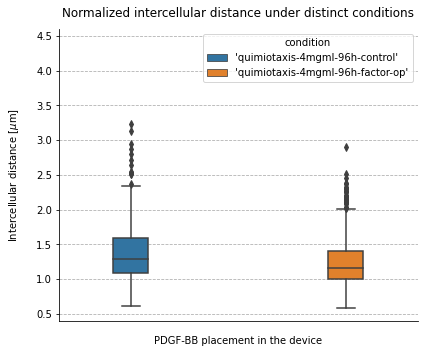

In [10]:
normalized_df = high_density_df.copy()

neighbors = 5
normalized_df = normalized_df[normalized_df['neighborhood'] == neighbors]

normalized_df['norm_value'] = normalized_df['value']/normalization_value

# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data=normalized_df, 
            x='condition', y='norm_value', 
            hue='condition', ax=ax, width=0.4)

ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Normalized intercellular distance under distinct conditions', y=1.02)
ax.set_xticks([])
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
ax.set_ylim(0.4, 4.6)
sns.despine()
plt.tight_layout()

#### 2.5 mg/mL

In [11]:
neighbors = 5
data_control = control_df[control_df['neighborhood'] == neighbors]['value'].values
data_mono = mono_df[mono_df['neighborhood'] == neighbors]['value'].values
data_opp = opp_df[opp_df['neighborhood'] == neighbors]['value'].values

fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

print(pvalue)

0.0013866395045649654


In [12]:
neighbor_data = single_df[single_df['neighborhood'] == 5]
tukey = pairwise_tukeyhsd(neighbor_data['value'], neighbor_data['condition'], alpha=p_thresh)
print(tukey)

                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
                 group1                                  group2                meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------------------------------------------------------
'quimiotaxis-1canal-2_5mgml-96h-control' 'quimiotaxis-1canal-2_5mgml-96h-mono'  10.5049 0.3413  -7.1093 28.1191  False
'quimiotaxis-1canal-2_5mgml-96h-control'   'quimiotaxis-1canal-2_5mgml-96h-op' -12.8495 0.0657 -26.3368  0.6378  False
   'quimiotaxis-1canal-2_5mgml-96h-mono'   'quimiotaxis-1canal-2_5mgml-96h-op' -23.3544 0.0019 -39.3996 -7.3092   True
----------------------------------------------------------------------------------------------------------------------


#### 4.0 mg/mL 

In [13]:
neighbors = 5

data = high_density_df[high_density_df['neighborhood'] == neighbors]

data_control = data[data['condition'].str.contains('control')]['value']
data_opp = data[data['condition'].str.contains('op')]['value']

fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

print(pvalue)

9.140935977400979e-12


## Read the computational data

In [29]:
def compute_distance(cells, id1, id2):
    """Returns the 2D distance between two cells"""
    
    cell1 = cells[cells['ID'] == id1]
    pos1 = (cell1['position_x'], cell1['position_y'])
    cell2 = cells[cells['ID'] == id2]
    pos2 = (cell2['position_x'], cell2['position_y'])
    
    distance = dist.euclidean(pos1, pos2)
    
    return distance

def get_pair(i, j):
    """Returns a pair to serve as a dict key to avoid computing the same distance twice"""
    if i < j:
        pair = (i, j)
    else: 
        pair = (j, i)
        
    return pair

CELL_RADIUS = 8
VARIABLES = ['ID', 'position_x', 'position_y', 'position_z']
BASE_FOLDER = Path('distances-data') 

number_of_neighbors = 5
timestep = 4
conditions = ['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op',
              '4mgml-96h-control', '4mgml-96h-op']


all_conditions = []

for j, condition in enumerate(conditions):
    distance_pairs = {}
    day_dist = {}
    average_distance = []
    cells_list = []
    cells = optimization.get_cell_data(timestep, 
                                       BASE_FOLDER / condition, 
                                       VARIABLES)

    rep_df = pd.DataFrame(cells)

    rep_df['replicate'] = replicate
    rep_df['condition'] = condition

    if condition.find('4mgml') != -1:
        rep_df['Density'] = '4 mg/mL'
    else:
        rep_df['Density'] = '2.5 mg/mL'
    if condition.find('control') != -1:
        rep_df['PDGF Placement'] = 'Control'
    else:
        if condition.find('mono') != -1:
            rep_df['PDGF Placement'] = 'Cell chamber'
        else:
            rep_df['PDGF Placement'] = 'Opposite chamber'

    cells_list.append(rep_df)

    # Reducing the height of interest to be more similar to 2D microscopy
    rep_df = rep_df[rep_df['position_z'].between(-40, 40)]

    cell_df = pd.concat(cells_list)
    
    # Sampling the cells to be more similar to 2D microscopy
    cell_df = cell_df.sample(200)
    all_conditions.append(cell_df)
    
cells_df = pd.concat(all_conditions)

cells_df = cells_df.reset_index(drop=True)
cells_df

,ID,position_x,position_y,position_z,replicate,condition,Density,PDGF Placement
0,175.0,101.296685,211.163917,-28.493493,2,1ch-96h-control,2.5 mg/mL,Control
1,129.0,155.726387,208.685023,-37.399125,2,1ch-96h-control,2.5 mg/mL,Control
2,71.0,-396.343923,25.267403,-1.585149,2,1ch-96h-control,2.5 mg/mL,Control
3,97.0,-284.660325,190.043280,58.740022,2,1ch-96h-control,2.5 mg/mL,Control
4,170.0,16.447584,145.594089,-79.060185,2,1ch-96h-control,2.5 mg/mL,Control
...,...,...,...,...,...,...,...,...
995,81.0,-38.157830,483.576124,-6.752554,2,4mgml-96h-op,4 mg/mL,Opposite chamber
996,161.0,-164.814014,252.658727,-61.254313,2,4mgml-96h-op,4 mg/mL,Opposite chamber
997,117.0,439.081245,563.449786,63.719229,2,4mgml-96h-op,4 mg/mL,Opposite chamber
998,175.0,-130.992679,252.551961,-100.674799,2,4mgml-96h-op,4 mg/mL,Opposite chamber


In [30]:
# Computing the distance between neighbors
cells_df['dist_to_neighbors'] = np.nan

for j, condition in enumerate(conditions):
    condition_df = cells_df[cells_df['condition'] == condition]
    
    for replicate in range(1, 3):
        # Create a dict to store distance values (so that a pair of cells only requires computing once)
        distance_pairs = {}
        # Create a dict to store the distance data for each day
        day_dist = {}
        
        # Read the data
        rep_cells = condition_df[condition_df['replicate'] == replicate]
        for current_cell in rep_cells['ID'].unique():
            # For each cell, compute the distance to other cells
            cell_index = cells_df[(cells_df['replicate'] == replicate) &
                                  (cells_df['ID'] == current_cell) &
                                  (cells_df['condition'] == condition)].index
            distances = []
            for i in rep_cells['ID'].unique():
                if i == current_cell:
                    continue
                    
                # Check if the distance was computed before. If it already was, use the value
                # If not, compute it
                pair = get_pair(i, current_cell)
                if pair not in distance_pairs.keys():
                    distance = compute_distance(rep_cells, current_cell, i)
                    distances.append(distance)
                    distance_pairs[pair] = distance
                else:
                    distances.append(distance_pairs[pair])
                    
            # Get the n closest neighbors
            smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
            # Get and store the average distance for the n neighbors
            average_neighborhood = smallest_distances.mean()
            cells_df.loc[cell_index, 'dist_to_neighbors'] = average_neighborhood

<AxesSubplot:xlabel='Density', ylabel='dist_to_neighbors'>

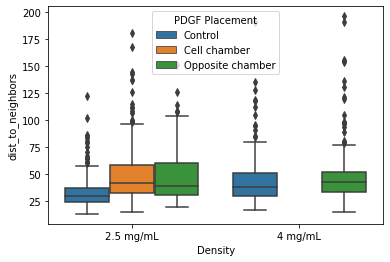

In [31]:
sns.boxplot(data=cells_df, x='Density', y='dist_to_neighbors', hue='PDGF Placement')

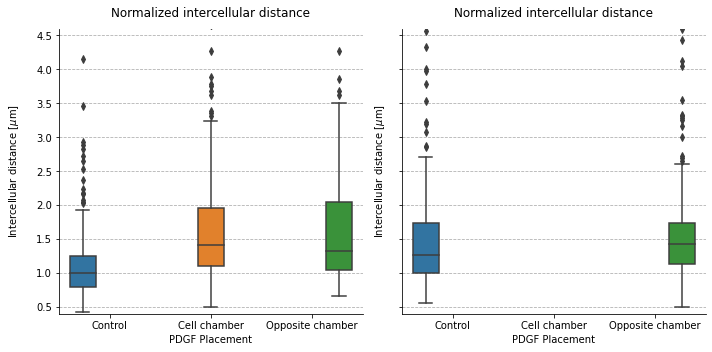

In [32]:
norm_value = cells_df[(cells_df['PDGF Placement'] == 'Control') & 
                       (cells_df['Density'] == '2.5 mg/mL')]['dist_to_neighbors'].median()

cells_df['norm_distance'] = cells_df['dist_to_neighbors']/norm_value
g = sns.catplot(data=cells_df, x='PDGF Placement', y='norm_distance', 
                hue='PDGF Placement', col='Density', kind='box')

for ax in g.axes.flatten():
    ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
    ax.set_title('Normalized intercellular distance', y=1.02)

    ax.set_axisbelow(True)
    ax.set_ylim(0.4, 4.6)
    ax.grid(axis='y', linestyle='--')
    
sns.despine()
plt.tight_layout()

### Statistical analysis

*Note: Even though the cells were sampled, this analysis was repeated for multiple samples and the results are consistent*

In [33]:
data_control = cells_df[cells_df['condition'] == '1ch-96h-control']['norm_distance'].values
data_mono = cells_df[cells_df['condition'] == '1ch-96h-mono']['norm_distance'].values
data_opp = cells_df[cells_df['condition'] == '1ch-96h-op']['norm_distance'].values

fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

print(pvalue)

9.262486160380836e-14


In [34]:
low_density = cells_df[cells_df['condition'].isin(['1ch-96h-control',
                                                 '1ch-96h-mono',
                                                 '1ch-96h-op'])]

tukey = pairwise_tukeyhsd(low_density['norm_distance'], low_density['condition'], alpha=p_thresh)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1        group2    meandiff p-adj   lower  upper  reject
------------------------------------------------------------------
1ch-96h-control 1ch-96h-mono    0.577  0.001   0.393  0.761   True
1ch-96h-control   1ch-96h-op   0.4904  0.001  0.3064 0.6745   True
   1ch-96h-mono   1ch-96h-op  -0.0866 0.5116 -0.2706 0.0975  False
------------------------------------------------------------------


In [35]:
data_control = cells_df[cells_df['condition'] == '4mgml-96h-control']['norm_distance'].values
data_opp = cells_df[cells_df['condition'] == '4mgml-96h-op']['norm_distance'].values

fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

print(pvalue)

0.033793969587030175
